In [46]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import random
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import pathlib
import numpy as np
import pandas as pd

In [30]:
train_data_path =  "../medical_image_analysis/dataset/train/"
test_data_path =  "../medical_image_analysis/dataset/test/"
val_data_path =  "../medical_image_analysis/dataset/val/"

In [34]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [35]:
data_dir = pathlib.Path(train_data_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')if item.is_dir()]))
print(class_names)

['NORMAL' 'PNEUMONIA']


In [27]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}") 
  return img

Image shape: (1542, 1778)


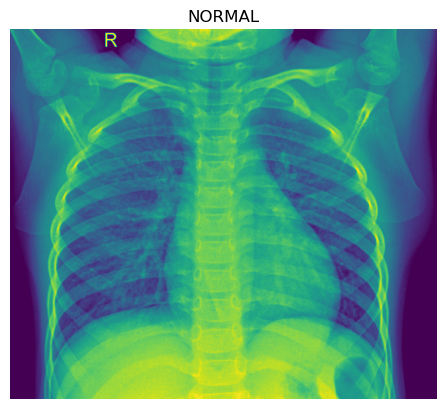

In [28]:
img = view_random_image(target_dir="../medical_image_analysis/dataset/train/",
                        target_class="NORMAL")

In [41]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

In [39]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_data = train_datagen.flow_from_directory(train_data_path,
                                                 target_size = (224, 224),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')
testing_data = test_datagen.flow_from_directory(test_data_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')


Found 4152 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# creating callbacks
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 5)

In [42]:
vgg_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = vgg_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 6s 0us/step


In [43]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()
history = model.fit( training_data,validation_data=testing_data, epochs=5,
                     steps_per_epoch=len(training_data), validation_steps=len(testing_data),callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling_lay  (None, 512)               0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              104960

2024-01-12 03:43:09.285385: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-01-12 03:43:09.430672: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  1/130 [..............................] - ETA: 11:29 - loss: 0.6709 - accuracy: 0.6250

2024-01-12 03:43:13.705368: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-01-12 03:43:13.803191: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  2/130 [..............................] - ETA: 9:48 - loss: 0.7911 - accuracy: 0.7031 

2024-01-12 03:43:18.311639: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


130/130 [==============================] - 884s 7s/step - loss: 0.3609 - accuracy: 0.8278 - val_loss: 0.3307 - val_accuracy: 0.8718
Epoch 2/5
130/130 [==============================] - 992s 8s/step - loss: 0.2151 - accuracy: 0.9126 - val_loss: 0.2797 - val_accuracy: 0.8782
Epoch 3/5
130/130 [==============================] - 1076s 8s/step - loss: 0.2085 - accuracy: 0.9169 - val_loss: 0.2769 - val_accuracy: 0.8766
Epoch 4/5
130/130 [==============================] - 923s 7s/step - loss: 0.1808 - accuracy: 0.9302 - val_loss: 0.2854 - val_accuracy: 0.8894
Epoch 5/5
130/130 [==============================] - 887s 7s/step - loss: 0.1785 - accuracy: 0.9265 - val_loss: 0.3211 - val_accuracy: 0.8670


In [44]:
model.evaluate(testing_data)

20/20 [==============================] - 85s 4s/step - loss: 0.3211 - accuracy: 0.8670


[0.3210904598236084, 0.8669871687889099]

<Axes: >

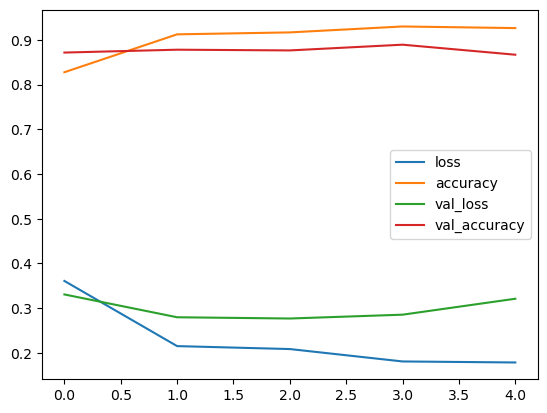

In [47]:
pd.DataFrame(history.history).plot()

In [48]:
y_pred = model.predict(testing_data)

20/20 [==============================] - 88s 4s/step


In [49]:
y_pred[:5]

array([[0.925163  ],
       [0.3350924 ],
       [0.98519444],
       [0.97000515],
       [0.99545497]], dtype=float32)